<a href="https://colab.research.google.com/github/hawat629/comerce/blob/master/Defi%20toulouse/%20classif%20/MD%20distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Considérons le problème d'estimation de la probabilité qu'un point de données appartient à une distribution.
Notre première étape serait de trouver le centroïde ou le centre de masse des points d'échantillonnage. 
Intuitivement, plus le point en question est proche de ce centre de masse, plus il est susceptible d'appartenir à 
l'ensemble. Cependant, nous devons également savoir si l'ensemble est réparti sur une large plage ou une petite plage, 
afin de pouvoir décider si une distance donnée du centre est notable ou non. 
L'approche simpliste consiste à estimer l'écart type des distances des points d'échantillonnage par rapport au 
centre de masse. En le branchant dans la distribution normale, nous pouvons déduire la probabilité que 
le point de données appartienne à la même distribution.
on s'attendrait à ce que la probabilité que le point d'essai appartenant à l'ensemble dépende non seulement de la distance du centre de masse, mais également de la direction. Dans les directions où l'ellipsoïde a un axe court, le point de test doit être plus proche, tandis que dans celles où l'axe est long, le point de test peut être plus éloigné du centre.
Sur le plan mathématique, l'ellipsoïde qui représente le mieux la distribution de probabilité de l'ensemble peut être estimé en calculant la matrice de covariance des échantillons. La distance de Mahalanobis (MD) est la distance du point d'essai du centre de masse divisée par la largeur de l'ellipsoïde dans la direction du point d'essai.

Afin d'utiliser le MD pour classer un point de test comme appartenant à l'une des N classes, on estime d'abord la matrice de covariance de chaque classe, généralement basée sur des échantillons connus pour appartenir à chaque classe. Dans notre cas, comme nous ne souhaitons classer que «normal» vs «anomalie», nous utilisons des données d'entraînement qui ne contiennent que des conditions de fonctionnement normales pour calculer la matrice de covariance. Puis, étant donné un échantillon de test, nous calculons le MD à la classe «normale», et classons le point de test comme une «anomalie» si la distance est supérieure à un certain seuil.




In [0]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Classification/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip install h5py
import h5py

In [0]:
train = h5py.File(path + "train.hdf5", "r+")
df_train = train["dftrain"]
X_train = np.asarray(df_train["block0_values"])
test = h5py.File(path + "test.hdf5", "r+")
df_test = test["dffinal"]
X_test = np.asarray(df_test["block0_values"])

In [0]:

#reduction de la dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
# on a choisir de reduire à 10 variable après qu'on a ploter la courbe PCA et on decider le nombre de variable qui maximise le nombre d'anomalie detecter


In [0]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [0]:
# calcule de la Mahanolibis distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [0]:
#calcule du threshold
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [0]:
#detection d'anomalie
def MD_detectOutliers(dist,threshold, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [0]:
#detection d'anomalie
def MD_detectOutliers(dist,threshold, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [0]:
#s'assurer que la matrice est inversible avant l'inverser
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return 1
        except np.linalg.LinAlgError:
            return 0
    else:
        return 0

In [0]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)


In [0]:
mean_distr = data_train.mean(axis=0)

In [0]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)


Text(0.5, 0, 'Mahalanobis dist')

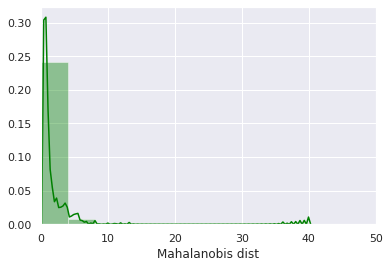

In [0]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,50])
plt.xlabel('Mahalanobis dist')

(0.0, 1000)

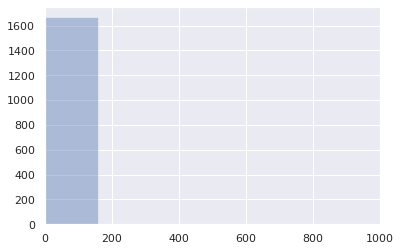

In [0]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,1000])

In [0]:
#tester l'algo sur train pour s'assurer qu'il marche
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train

In [0]:
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
anomaly['Anomaly'] = (anomaly['Mob dist'] > anomaly['Thresh'])*1
anomaly

,Mob dist,Thresh,Anomaly
0,0.336049,2.814542,0
1,0.423170,2.814542,0
2,0.368784,2.814542,0
3,0.232924,2.814542,0
4,0.201772,2.814542,0
...,...,...,...
1912,0.133156,2.814542,0
1913,0.588540,2.814542,0
1914,0.144457,2.814542,0
1915,0.330719,2.814542,0


In [0]:
#nombre d'anomalie detecter
N = 0
for i in range (1917):
    if (dist_test[i] > threshold): 
        N = N+1
        print(i)
print(N)

24
37
54
70
94
156
198
225
256
268
321
323
358
364
366
367
376
458
493
520
549
557
576
595
596
654
675
691
693
696
730
785
813
822
840
841
854
863
871
883
921
931
979
1005
1017
1044
1062
1085
1098
1101
1111
1129
1138
1139
1200
1223
1226
1227
1269
1319
1341
1346
1352
1356
1363
1370
1377
1390
1403
1448
1502
1540
1559
1571
1579
1596
1607
1621
1639
1661
1685
1715
1735
1777
1788
1794
1829
1838
1895
89
